In [2]:
"""
===========================================================
Using PyPARRM to filter out stimulation artefacts from data
===========================================================

This example demonstrates how the PARRM algorithm :footcite:`DastinEtAl2021`
can be used to identify and remove stimulation artefacts from
electrophysiological data in the PyPARRM package.
"""

import numpy as np
import cupy as cp
from matplotlib import pyplot as plt

from pyparrm import PARRM
from pyparrm._utils._power import compute_psd

fpath = "C:/Users/User/Documents/GitHub/UGRP/data/synthetic_data/"
data = np.load(fpath + "contaminated_by_realistic" + ".npy")

fs = 2000  # Hz
artefact_freq = 130  # Hz

print(
    f"`data` has shape: ({data.shape[0]} channel, "
    f"{data.shape[1]} timepoints)\n"
    f"`data` duration: {data.shape[1] / fs :.2f} seconds"
)

`data` has shape: (1000 channel, 4000 timepoints)
`data` duration: 2.00 seconds


In [3]:
parrm = PARRM(
    data=data,
    sampling_freq=fs,
    artefact_freq=artefact_freq,
    verbose=False,  # silenced to reduce pqdm output clutter
)
parrm.find_period()

print(f"Estimated artefact period: {parrm.period :.4f}")

Estimated artefact period: 16.0000


In [4]:
winTime = 0.5 
skipTime = winTime / 10  
perDist = 0.01
winSize = int(fs*winTime)  
skipSize = int(fs*skipTime)
winDir = "both"

parrm.create_filter(
    filter_half_width=winSize,
    omit_n_samples=skipSize,
    filter_direction=winDir,
    period_half_width=perDist,
)

filtered_data = parrm.filter_data()  # other data to filter can be given here

# comparison to true artefact-free data
artefact_free = np.load(fpath + "clean_data" + ".npy")

C:\Users\User\AppData\Local\Temp\ipykernel_23992\240297340.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


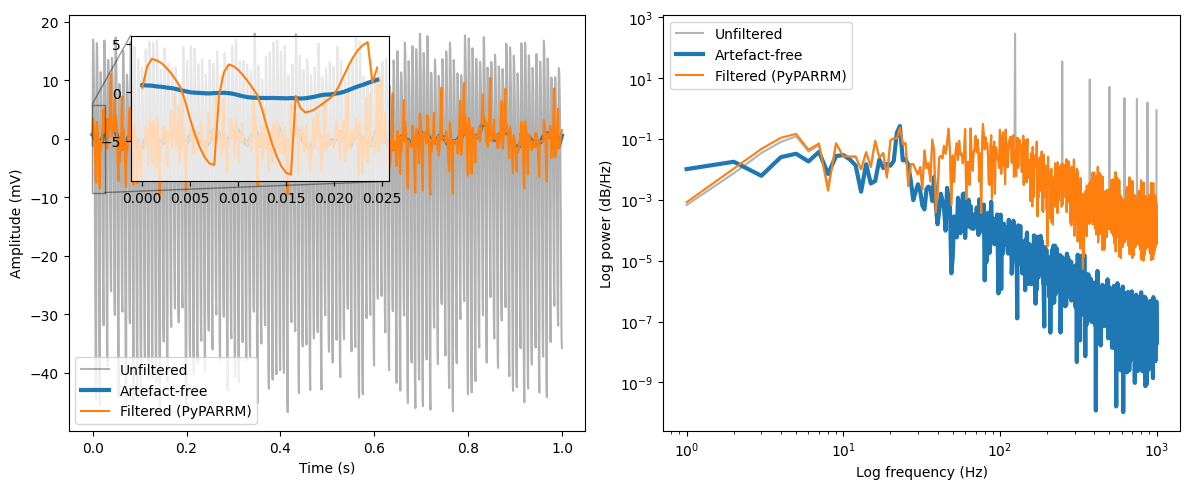

In [7]:
t = np.linspace(0, 2, num=4000) 
start_time = 1; # [sec]
end_time = 2; # [sec]
start_pts = start_time*fs
end_pts = end_time*fs
times = np.arange(end_pts - start_pts) / fs

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
inset_axis = axes[0].inset_axes((0.12, 0.6, 0.5, 0.35))

# main timeseries plot
axes[0].plot(
    times, data[0, start_pts:end_pts], color="black", alpha=0.3, label="Unfiltered"
)
axes[0].plot(
    times, artefact_free[0, start_pts:end_pts], linewidth=3, label="Artefact-free"
)
axes[0].plot(times, filtered_data[0, start_pts:end_pts], label="Filtered (PyPARRM)")
axes[0].legend()
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude (mV)")

# timeseries inset plot
inset_axis.plot(times[:50], artefact_free[0, start_pts : start_pts + 50], linewidth=3)
inset_axis.plot(times[:50], filtered_data[0, start_pts : start_pts + 50])
axes[0].indicate_inset_zoom(inset_axis, edgecolor="black", alpha=0.4)
inset_axis.patch.set_alpha(0.7)

# power spectral density plot
n_freqs = fs / 2
psd_freqs, psd_raw = compute_psd(
    data[0, start_pts:end_pts], fs, int(n_freqs * 2)
)
_, psd_filtered = compute_psd(
    filtered_data[0, start_pts:end_pts], fs, int(n_freqs * 2)
)
_, psd_artefact_free = compute_psd(
    artefact_free[0, start_pts:end_pts], fs, int(n_freqs * 2)
)

axes[1].loglog(
    psd_freqs, psd_raw, color="black", alpha=0.3, label="Unfiltered"
)
axes[1].loglog(
    psd_freqs, psd_artefact_free, linewidth=3, label="Artefact-free"
)
axes[1].loglog(psd_freqs, psd_filtered, label="Filtered (PyPARRM)")
axes[1].legend()
axes[1].set_xlabel("Log frequency (Hz)")
axes[1].set_ylabel("Log power (dB/Hz)")

fig.tight_layout()
fig.show()